In [34]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell 1: Imports & User Parameters (centralized)
# ──────────────────────────────────────────────────────────────────────────────

import numpy as np
import pandas as pd
import rasterio
from rasterio.merge import merge
from rasterio.vrt import WarpedVRT
import pyproj
from pystac_client import Client
import planetary_computer
import matplotlib.pyplot as plt
import math
from math import sin, cos, tan, radians
from matplotlib.collections import LineCollection
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# ─── USER‐DEFINED PARAMETERS ───────────────────────────────────────────────────
obs_lat = 42.940389
obs_lon = -122.107171
eye_height = 1.80

max_vis = 20_000
padding = 1000

azimuths = np.arange(0, 360, 1)
stac_endpoint = "https://planetarycomputer.microsoft.com/api/stac/v1"
three_dep_collection = "3dep-seamless"
nasadem_collection = "nasadem"

angle_step = 0.01
max_angle = 90.0
angle_list = np.arange(angle_step, max_angle + 1e-6, angle_step)
r_step = 5.0

In [35]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell 2: Helper Functions (for DEM sampling, hillshade, extent, etc.)
# ──────────────────────────────────────────────────────────────────────────────

def utm_to_dem_rc(x_utm, y_utm, dem_affine):
    inv_affine = ~dem_affine
    col_f, row_f = inv_affine * (x_utm, y_utm)
    return row_f, col_f

def sample_dem_at_utm(x_utm, y_utm, dem_window, dem_affine):
    row_f, col_f = utm_to_dem_rc(x_utm, y_utm, dem_affine)
    i0, j0 = int(np.floor(row_f)), int(np.floor(col_f))
    di, dj = row_f - i0, col_f - j0
    if (i0 < 0 or j0 < 0 or i0 + 1 >= dem_window.shape[0] or j0 + 1 >= dem_window.shape[1]):
        return np.nan
    z00 = dem_window[i0,   j0]
    z10 = dem_window[i0,   j0+1]
    z01 = dem_window[i0+1, j0]
    z11 = dem_window[i0+1, j0+1]
    if np.isnan([z00, z10, z01, z11]).any():
        return np.nan
    z_upper = z00 * (1 - dj) + z10 * dj
    z_lower = z01 * (1 - dj) + z11 * dj
    return z_upper * (1 - di) + z_lower * di

def utm_offset_from_observer(azimuth_deg, distance_m, obs_x, obs_y):
    θ = radians(azimuth_deg)
    dx = distance_m * sin(θ)
    dy = distance_m * cos(θ)
    return obs_x + dx, obs_y + dy

def compute_hillshade(dem, affine, azimuth=315, altitude=45):
    x_res = affine.a
    y_res = abs(affine.e)
    dz_dx, dz_dy = np.gradient(dem, x_res, y_res)
    slope = np.pi/2 - np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
    aspect = np.arctan2(-dz_dx, dz_dy)
    az_rad = np.deg2rad(azimuth)
    alt_rad = np.deg2rad(altitude)
    return (
        np.sin(alt_rad) * np.sin(slope)
        + np.cos(alt_rad) * np.cos(slope) * np.cos(az_rad - aspect)
    )

def dynamic_extent(samples_patch, left, right, bottom, top, pad_frac=0.05):
    if not samples_patch.empty:
        x_min, x_max = samples_patch['x_utm'].min(), samples_patch['x_utm'].max()
        y_min, y_max = samples_patch['y_utm'].min(), samples_patch['y_utm'].max()
        x_pad = (x_max - x_min) * pad_frac
        y_pad = (y_max - y_min) * pad_frac
        return x_min - x_pad, x_max + x_pad, y_min - y_pad, y_max + y_pad
    else:
        return left, right, bottom, top

In [36]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell 3: Project Observer to UTM & Cache DEM Window in RAM (3DEP preferred, fallback to NASADEM)
# ──────────────────────────────────────────────────────────────────────────────

# Compute UTM zone number from observer longitude/latitude
zone_number = int((obs_lon + 180) / 6) + 1
hemisphere  = "north" if obs_lat >= 0 else "south"

dem_crs = pyproj.CRS.from_proj4(
    f"+proj=utm +zone={zone_number} +datum=WGS84 +units=m +{'north' if hemisphere=='north' else 'south'}"
)

# Build transformers between WGS84 (EPSG:4326) and UTM (dem_crs)
to_utm   = pyproj.Transformer.from_crs("EPSG:4326", dem_crs, always_xy=True)
to_wgs84 = pyproj.Transformer.from_crs(dem_crs, "EPSG:4326", always_xy=True)

# Transform observer lat/lon → UTM (obs_x, obs_y)
obs_x, obs_y = to_utm.transform(obs_lon, obs_lat)

# Compute UTM bounding box for circle of radius max_vis+padding around observer
dem_radius = max_vis + padding
xmin = obs_x - dem_radius
xmax = obs_x + dem_radius
ymin = obs_y - dem_radius
ymax = obs_y + dem_radius

# Convert that UTM-bbox back to geographic lat/lon bbox for STAC query
lon1, lat1 = to_wgs84.transform(xmin, ymin)
lon2, lat2 = to_wgs84.transform(xmin, ymax)
lon3, lat3 = to_wgs84.transform(xmax, ymin)
lon4, lat4 = to_wgs84.transform(xmax, ymax)

min_lon = min(lon1, lon2, lon3, lon4)
max_lon = max(lon1, lon2, lon3, lon4)
min_lat = min(lat1, lat2, lat3, lat4)
max_lat = max(lat1, lat2, lat3, lat4)

# Try 3DEP first, fallback to NASADEM if no 3DEP tiles found
def get_stac_items(collection, min_lon, min_lat, max_lon, max_lat):
    catalog = Client.open(stac_endpoint)
    search  = catalog.search(
        collections=[collection],
        bbox=[min_lon, min_lat, max_lon, max_lat],
    )
    items = list(search.get_items())
    return items

items = get_stac_items(three_dep_collection, min_lon, min_lat, max_lon, max_lat)
print(f"3DEP: Found {len(items)} tiles for bounding box ({min_lon:.5f}, {min_lat:.5f}, {max_lon:.5f}, {max_lat:.5f})")
if len(items) > 10:
    print("Warning: Large number of DEM tiles requested. Consider reducing max_vis or padding for faster performance.")

if items:
    print("Using 3DEP seamless tiles (priority).")
    dem_source = "3dep"
else:
    print("No 3DEP tiles found for this area, falling back to NASADEM.")
    items = get_stac_items(nasadem_collection, min_lon, min_lat, max_lon, max_lat)
    print(f"NASADEM: Found {len(items)} tiles.")
    if not items:
        raise RuntimeError("No elevation tiles found in either 3DEP or NASADEM for this area.")
    dem_source = "nasadem"

# Sign each STAC item so that asset hrefs become authenticated URLs
signed_items = [planetary_computer.sign(item) for item in items]

# Extract signed COG URLs from the correct asset key
if dem_source == "3dep":
    # 3DEP asset key is "data"
    tile_urls = [item.assets["data"].href for item in signed_items]
else:
    # NASADEM asset key is "elevation"
    tile_urls = [item.assets["elevation"].href for item in signed_items]

# Open each COG and wrap it in a WarpedVRT to reproject on-the-fly to dem_crs
vrt_datasets = []
for url in tile_urls:
    src = rasterio.open(url)
    vrt = WarpedVRT(src, crs=dem_crs)
    vrt_datasets.append(vrt)

# Merge all VRT datasets, reading only the UTM window [xmin, ymin, xmax, ymax]
mosaic_arr, mosaic_transform = merge(
    vrt_datasets,
    bounds=(xmin, ymin, xmax, ymax),
    res=vrt_datasets[0].res    # use the resolution of the first VRT
)
dem_window = mosaic_arr[0]
dem_affine = mosaic_transform
dem_nrows, dem_ncols = dem_window.shape

print(
    f"Cached DEM window ({dem_source}): {dem_nrows} rows × {dem_ncols} cols → "
    f"≈ {dem_nrows * dem_ncols * 4 / 1e6:.1f} MB in RAM"
)
row_o, col_o = rasterio.transform.rowcol(dem_affine, obs_x, obs_y)
z_obs = dem_window[row_o, col_o]
z_eye = z_obs + eye_height

print(f"Observer ground elevation ≈ {z_obs:.2f} m, eye elevation = {z_eye:.2f} m")
print(f"DEM window UTM bounds: xmin={xmin:.2f}, xmax={xmax:.2f}, ymin={ymin:.2f}, ymax={ymax:.2f}")

3DEP: Found 8 tiles for bounding box (-122.36648, 42.74902, -121.84629, 43.13120)
Using 3DEP seamless tiles (priority).
Cached DEM window (3dep): 4644 rows × 4644 cols → ≈ 86.3 MB in RAM
Observer ground elevation ≈ 1882.01 m, eye elevation = 1883.81 m
DEM window UTM bounds: xmin=551843.55, xmax=593843.55, ymin=4733581.79, ymax=4775581.79


In [37]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell 4: Vectorized Horizon‐Cap Stage → find Cap(θ, α) for each azimuth & each α
# ──────────────────────────────────────────────────────────────────────────────

# Precompute inverse affine for DEM lookup
inv_affine = ~dem_affine

# Build lists of horizon‐angles (α) and sample‐ranges (r)
angle_list = np.arange(angle_step, max_angle + 1e-6, angle_step)
tans       = np.tan(np.deg2rad(angle_list))
rs         = np.arange(r_step, max_vis + r_step, r_step)

tol_z = 1e-3  # tolerance for flat surface (e.g., ocean/water/flat ground)

records = []
visible_samples = []

for θ in azimuths:
    θ_rad = radians(θ)
    dxs = rs * sin(θ_rad)
    dys = rs * cos(θ_rad)
    xs  = obs_x + dxs
    ys  = obs_y + dys

    rows_f, cols_f = utm_to_dem_rc(xs, ys, dem_affine)
    rows = np.clip(rows_f.astype(int), 0, dem_window.shape[0] - 1)
    cols = np.clip(cols_f.astype(int), 0, dem_window.shape[1] - 1)
    elevs = dem_window[rows, cols]

    # Find first non-flat ("wake-up") pixel
    wake_idx = None
    for i in range(len(rs)):
        z_t = elevs[i]
        if np.isnan(z_t):
            z_t = z_obs
        if abs(z_t - z_obs) >= tol_z:
            wake_idx = i
            break
    if wake_idx is None:
        continue  # all flat, skip this azimuth

    # Collect visible points after wake-up, unified-occlusion
    max_elev_ang = np.degrees(np.arctan2(elevs[wake_idx] - z_eye, rs[wake_idx]))
    for i in range(wake_idx, len(rs)):
        z_r = elevs[i]
        if np.isnan(z_r):
            z_r = z_obs
        if abs(z_r - z_obs) < tol_z:
            continue  # skip flat water/ground

        elev_ang = np.degrees(np.arctan2(z_r - z_eye, rs[i]))
        if elev_ang >= max_elev_ang - 1e-6:
            visible_samples.append({
                'az_deg': θ,
                'r_m': rs[i],
                'z_elev': z_r,
                'x_utm': xs[i],
                'y_utm': ys[i],
                'row_f': rows_f[i],
                'col_f': cols_f[i],
                'row': rows[i],
                'col': cols[i],
                'above_eye': z_r > z_eye,
                'slope': (z_r - z_eye) / rs[i],
                'horizon_angle_deg': elev_ang
            })
            max_elev_ang = elev_ang

    # Optionally, append the "cap" point for this azimuth if it exists and is not flat

    # horizon-cap logic
    slopes = (elevs - z_eye) / rs
    for α, t in zip(angle_list, tans):
        hits = np.nonzero(slopes > t)[0]
        if hits.size:
            i = hits[0]
            records.append({
                'az_deg':             θ,
                'horizon_angle_deg':  α,
                'r_m':                rs[i],
                'z_elev':             elevs[i],
                'x_utm':              xs[i],
                'y_utm':              ys[i],
                'row_f':              rows_f[i],
                'col_f':              cols_f[i],
                'row':                rows[i],
                'col':                cols[i],
            })

# Build DataFrame once
pc_df = pd.DataFrame.from_records(records)
print(f"[Vectorized] Found {len(pc_df)} horizon‐cap points.")
pc_df.head()

# Only visible points (not hidden by terrain, not flat)
visible_samples_df = pd.DataFrame.from_records(visible_samples)
print(f"[Viewshed] Collected {len(visible_samples_df)} visible points (not hidden by terrain, not flat).")
visible_samples_df.head()

[Vectorized] Found 159022 horizon‐cap points.
[Viewshed] Collected 17452 visible points (not hidden by terrain, not flat).


,az_deg,r_m,z_elev,x_utm,y_utm,row_f,col_f,row,col,above_eye,slope,horizon_angle_deg
0,0,3745.0,1882.054443,572843.548105,4.758327e+06,1907.879282,2321.962615,1907,2321,False,-0.000468,-0.026791
1,0,3750.0,1882.054443,572843.548105,4.758332e+06,1907.326434,2321.962615,1907,2321,False,-0.000467,-0.026755
2,0,3755.0,1884.989868,572843.548105,4.758337e+06,1906.773585,2321.962615,1906,2321,True,0.000315,0.018071
3,0,3765.0,1890.716797,572843.548105,4.758347e+06,1905.667889,2321.962615,1905,2321,True,0.001836,0.105175
4,0,3800.0,1893.137085,572843.548105,4.758382e+06,1901.797951,2321.962615,1901,2321,True,0.002456,0.140699


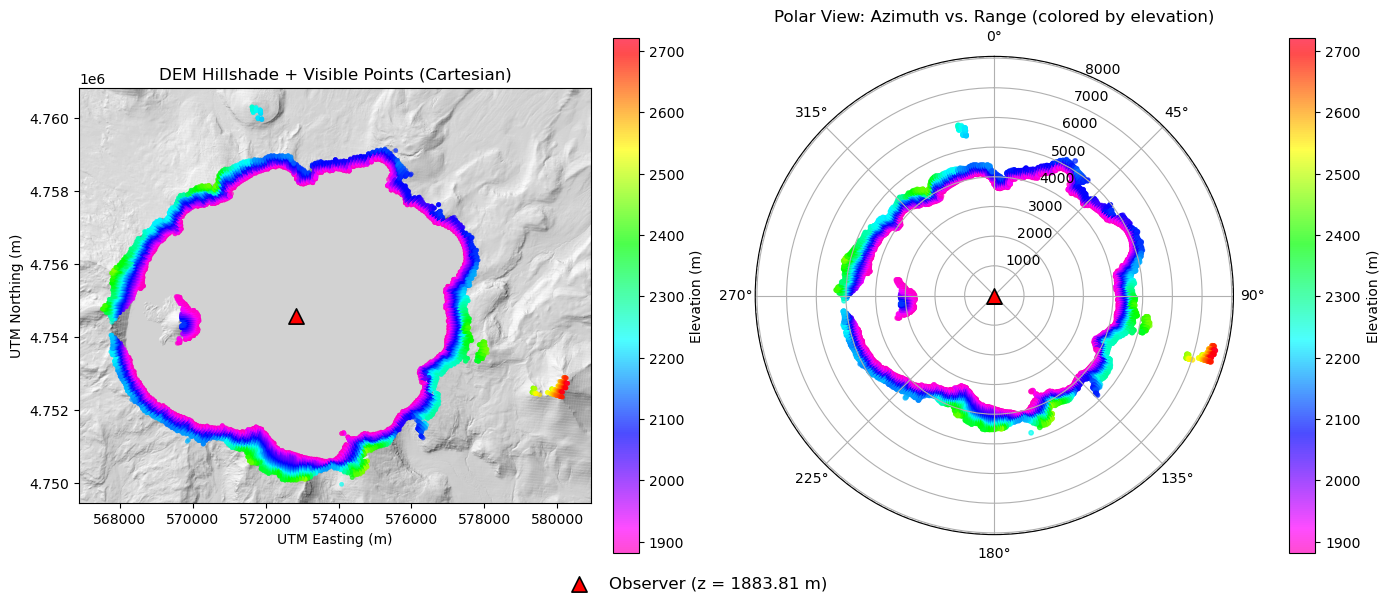

In [38]:
# ────────────────────────────────────────────────────────────────────────────── 
# Cell 5: DEM Patch + Visible Points (Cartesian)  &  Polar Scatter
# ──────────────────────────────────────────────────────────────────────────────

# Define patch radius around observer (e.g., 20.5 km) - this is overidden dynamically, but can be used to "zoom" into an extent
patch_radius = 20000  # meters, if you have a LARGE maximum visibility distance, you can set this to a similar value to "zoom" out

# Compute observer’s pixel location in dem_window
obs_col_f, obs_row_f = ~dem_affine * (obs_x, obs_y)
obs_row = int(round(obs_row_f))
obs_col = int(round(obs_col_f))

# Determine pixel radius for that patch (assuming square pixels)
pix_size = dem_affine.a  # meters per pixel (affine.a == pixel width in X)
pix_radius = int(math.ceil(patch_radius / pix_size))

# Compute row/col bounds for the patch, clipped to dem_window dimensions
row_min = max(obs_row - pix_radius, 0)
row_max = min(obs_row + pix_radius, dem_nrows - 1)
col_min = max(obs_col - pix_radius, 0)
col_max = min(obs_col + pix_radius, dem_ncols - 1)

# Extract DEM patch and compute its affine transform
dem_patch = dem_window[row_min : row_max + 1, col_min : col_max + 1]
patch_affine = dem_affine * rasterio.Affine.translation(col_min, row_min)

# Compute hillshade of the DEM patch
hillshade_patch = compute_hillshade(dem_patch, patch_affine)

# Determine extent of patch for plotting (left, right, bottom, top)
nrows_p, ncols_p = dem_patch.shape
left   = patch_affine.c
top    = patch_affine.f
right  = left + patch_affine.a * ncols_p
bottom = top  + patch_affine.e * nrows_p

# Filter only visible points (visible_samples_df) to those within the patch bounding box
in_patch_visible = (
    (visible_samples_df['x_utm'] >= left) &
    (visible_samples_df['x_utm'] <= right) &
    (visible_samples_df['y_utm'] >= bottom) &
    (visible_samples_df['y_utm'] <= top)
)
samples_patch = visible_samples_df[in_patch_visible].copy()

# Compute dynamic extent for points (with padding)
dyn_left, dyn_right, dyn_bottom, dyn_top = dynamic_extent(samples_patch, left, right, bottom, top)

# Begin figure with two subplots: Cartesian (left) and Polar (right)
fig = plt.figure(figsize=(14, 6))

# DEM Hillshade + All Sampled Points (Cartesian)
ax_cart = fig.add_subplot(1, 2, 1)

# Plot hillshade background
ax_cart.imshow(
    hillshade_patch,
    cmap='gray',
    extent=[left, right, bottom, top],
    origin='upper'
)

# Plot all visible points, colored by elevation
sc_cart = ax_cart.scatter(
    samples_patch['x_utm'],
    samples_patch['y_utm'],
    c=samples_patch['z_elev'],
    s=10,
    cmap='gist_rainbow_r',
    linewidth=0.2,
    alpha=0.7,
    marker='o'
)

# Mark observer location with a red triangle
obs_label = f"Observer (z = {z_eye:.2f} m)"
obs_marker_cart = ax_cart.scatter(
    [obs_x], [obs_y],
    marker='^', color='red', s=120, edgecolor='black', linewidth=1.2, zorder=10, label=obs_label
)

# Axis labels, title, colorbar
ax_cart.set_xlabel('UTM Easting (m)')
ax_cart.set_ylabel('UTM Northing (m)')
ax_cart.set_title('DEM Hillshade + Visible Points (Cartesian)')
ax_cart.set_aspect('equal', 'box')

# Set dynamic extent for the scatter plot (Cartesian)
ax_cart.set_xlim(dyn_left, dyn_right)
ax_cart.set_ylim(dyn_bottom, dyn_top)

# Compute the maximum radial distance from the observer to the visible points in the patch
if not samples_patch.empty:
    cart_r_max = np.sqrt(
        np.maximum(
            (samples_patch['x_utm'] - obs_x) ** 2 + (samples_patch['y_utm'] - obs_y) ** 2,
            1e-6
        )
    ).max()
    cart_r_max_pad = cart_r_max * 1.05
else:
    cart_r_max_pad = patch_radius

cbar1 = plt.colorbar(sc_cart, ax=ax_cart, fraction=0.046, pad=0.04)
cbar1.set_label('Elevation (m)')

# Right: Polar Scatter of All Visible Points
ax_polar = fig.add_subplot(1, 2, 2, projection='polar')

theta_rad = np.deg2rad(samples_patch['az_deg'].values)
r_vals    = samples_patch['r_m'].values
z_vals    = samples_patch['z_elev'].values

# Set color limits for consistent colorbar
zmin = samples_patch['z_elev'].min()
zmax = samples_patch['z_elev'].max()

# Plot all points in polar
sc_polar = ax_polar.scatter(
    theta_rad,
    r_vals,
    c=z_vals,
    s=10,
    cmap='gist_rainbow_r',
    alpha=0.7,
    marker='o',
    vmin=zmin,
    vmax=zmax
)

# Mark observer location in polar plot (r=0, θ=0) with a red triangle
obs_marker_polar = ax_polar.scatter(
    [0], [0],
    marker='^', color='red', s=120, edgecolor='black', linewidth=1.2, zorder=10
)

# Set radial limit to match the Cartesian plot's max radius (+5% padding)
ax_polar.set_ylim(0, cart_r_max_pad)

if len(r_vals) > 0:
    ax_polar.plot(np.linspace(0, 2*np.pi, 200), 
                  np.ones(200)*cart_r_max_pad, 
                  linestyle='--', linewidth=1, color='gray')
else:
    ax_polar.plot(np.linspace(0, 2*np.pi, 200), 
                  np.ones(200)*patch_radius, 
                  linestyle='--', linewidth=1, color='gray')

# Labels and colorbar for polar plot
ax_polar.set_title('Polar View: Azimuth vs. Range (colored by elevation)')
ax_polar.set_theta_zero_location('N')    # 0° = North (points “up”)
ax_polar.set_theta_direction(-1)         # clockwise increasing angles (0→359°)

cbar2 = plt.colorbar(sc_polar, ax=ax_polar, fraction=0.046, pad=0.10)
cbar2.set_label('Elevation (m)')

# Add a single legend for both subplots, placed below the plots
handles = [obs_marker_cart]
labels = [obs_label]
fig.legend(handles, labels, loc='lower center', ncol=1, frameon=False, fontsize=12, bbox_to_anchor=(0.5, -0.02))

# Final layout adjustments
plt.tight_layout(rect=[0, 0.03, 1, 1])  # leave space for legend
plt.show()

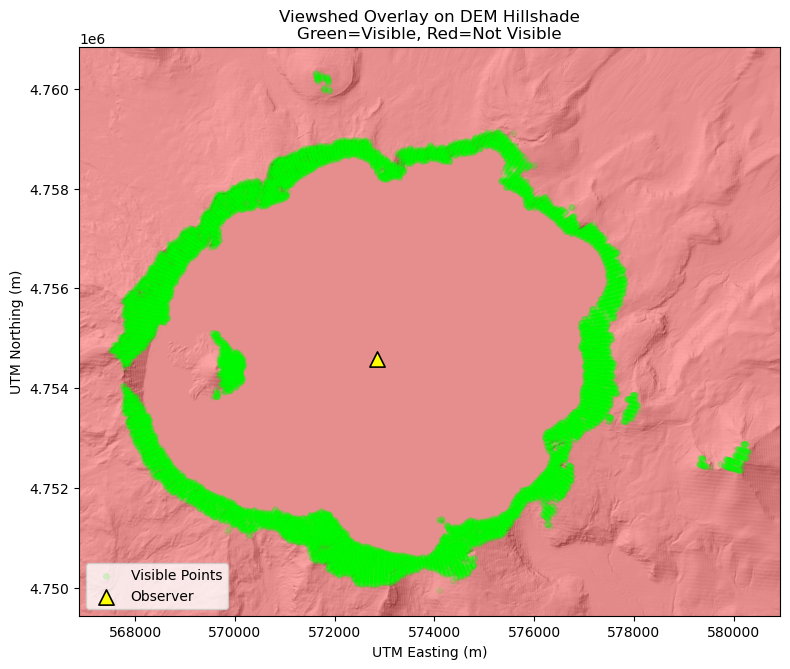

In [39]:
# ────────────────────────────────────────────────────────────────────────────── 
# Cell 6: # Viewshed mask from visible points, overlay on DEM hillshade patch (green=seen, red=unseen, hillshade visible below)
# ──────────────────────────────────────────────────────────────────────────────

# 1. Create a mask array for the patch (same shape as dem_patch)
viewshed_mask = np.zeros(dem_patch.shape, dtype=bool)

# 2. Map visible points to patch pixel indices
row_patch_offset = row_min
col_patch_offset = col_min

rows_in_patch = samples_patch['row'] - row_patch_offset
cols_in_patch = samples_patch['col'] - col_patch_offset

valid = (
    (rows_in_patch >= 0) & (rows_in_patch < dem_patch.shape[0]) &
    (cols_in_patch >= 0) & (cols_in_patch < dem_patch.shape[1])
)
rows_in_patch = rows_in_patch[valid].astype(int)
cols_in_patch = cols_in_patch[valid].astype(int)
viewshed_mask[rows_in_patch, cols_in_patch] = True

# 3. Compute dynamic extent for the viewshed overlay
dyn_left, dyn_right, dyn_bottom, dyn_top = dynamic_extent(samples_patch, left, right, bottom, top)

# 4. Plot hillshade with viewshed overlay
fig, ax = plt.subplots(figsize=(8, 8))

# Show hillshade as grayscale
ax.imshow(
    hillshade_patch,
    cmap='gray',
    extent=[left, right, bottom, top],
    origin='upper',
    alpha=0.85
)

# Overlay viewshed: green for seen, red for unseen, with alpha for blending
viewshed_rgba = np.zeros((*dem_patch.shape, 4), dtype=float)
viewshed_rgba[..., 0] = (~viewshed_mask) * 1.0  # Red for unseen
viewshed_rgba[..., 1] = (viewshed_mask) * 1.0   # Green for seen
viewshed_rgba[..., 3] = 0.35                    # Alpha for overlay (was 0.35, increase for more solid color)

ax.imshow(
    viewshed_rgba,
    extent=[left, right, bottom, top],
    origin='upper'
)

# Optionally, overlay visible points as large green dots for extra clarity
if not samples_patch.empty:
    ax.scatter(
        samples_patch['x_utm'],
        samples_patch['y_utm'],
        s=18,                # larger marker size for visibility
        color='lime',        # bright green
#        edgecolor='black',   # black edge for contrast
        linewidth=0.5,
        alpha=0.15,
        zorder=11,
        label='Visible Points'
    )

# Mark observer
ax.scatter([obs_x], [obs_y], marker='^', color='yellow', s=120, edgecolor='black', linewidth=1.2, zorder=12, label='Observer')

ax.set_xlabel('UTM Easting (m)')
ax.set_ylabel('UTM Northing (m)')
ax.set_title('Viewshed Overlay on DEM Hillshade\nGreen=Visible, Red=Not Visible')
ax.set_aspect('equal', 'box')

# Dynamically zoom to the extent of the viewshed
ax.set_xlim(dyn_left, dyn_right)
ax.set_ylim(dyn_bottom, dyn_top)

ax.legend(loc='lower left')
plt.tight_layout()
plt.show()

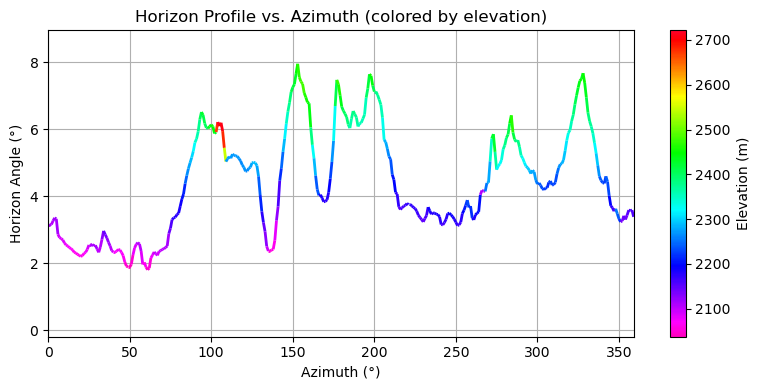

In [40]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell 7: 2D Horizon Profile (Azimuth vs. Horizon Angle)
# ──────────────────────────────────────────────────────────────────────────────

# Group by azimuth and take the maximum horizon_angle_deg at each azimuth
horizon = pc_df.groupby('az_deg')['horizon_angle_deg'].max().reset_index()
# For each azimuth, get the elevation at the horizon point
elev_at_horizon = pc_df.loc[pc_df.groupby('az_deg')['horizon_angle_deg'].idxmax()][['az_deg', 'z_elev']].reset_index(drop=True)

azimuths = horizon['az_deg'].values
h_angles = horizon['horizon_angle_deg'].values
elevs = elev_at_horizon['z_elev'].values

# Prepare segments for colored line
points = np.array([azimuths, h_angles]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Normalize elevation for colormap
norm = plt.Normalize(elevs.min(), elevs.max())
lc = LineCollection(segments, cmap='gist_rainbow_r', norm=norm)
lc.set_array(elevs)
lc.set_linewidth(2)

fig, ax = plt.subplots(figsize=(8,4))
line = ax.add_collection(lc)
ax.set_xlim(azimuths.min(), azimuths.max())
ax.set_ylim(h_angles.min() - 2, h_angles.max() + 1)
ax.set_xlabel('Azimuth (°)')
ax.set_ylabel('Horizon Angle (°)')
ax.set_title('Horizon Profile vs. Azimuth (colored by elevation)')
plt.colorbar(lc, ax=ax, label='Elevation (m)')
ax.grid(True)
plt.tight_layout()
plt.show()

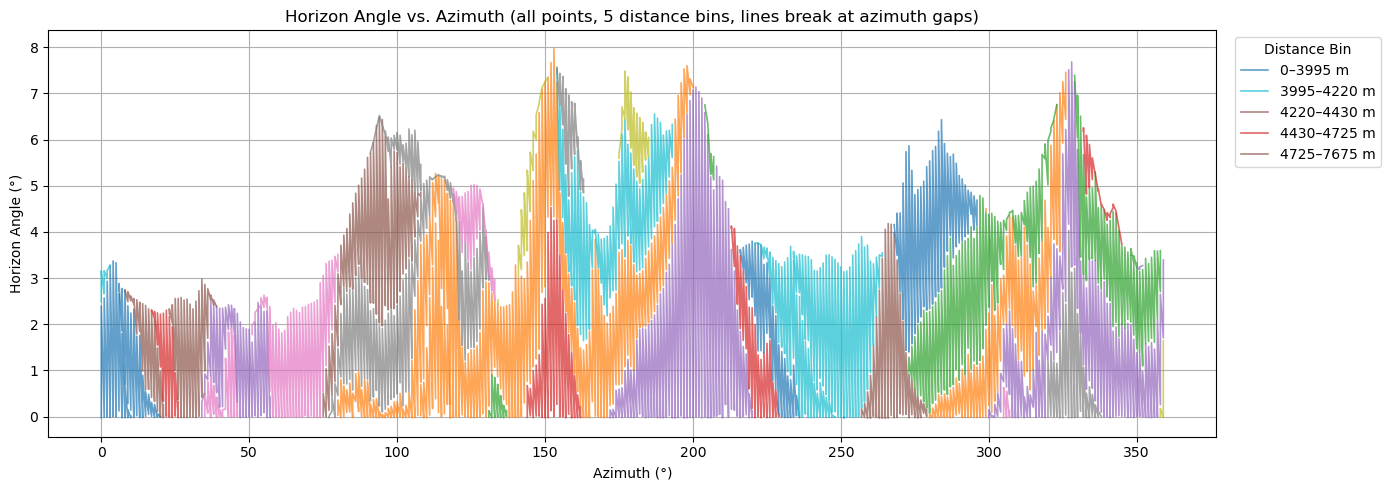

In [41]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell 8: # Horizon Angle vs. Azimuth, quantile-based distance bins (e.g., 6 bins) and all points
# ──────────────────────────────────────────────────────────────────────────────

# For each bin, plot all points (not just max per azimuth), but break lines at large azimuth gaps.
# Use more quantile bins (e.g., 6 bins: 0, 1/6, 2/6, ..., 1)
num_bins = 5
quantiles = np.linspace(0, 1, num_bins + 1)
distance_bins = np.quantile(samples_patch['r_m'], quantiles)
distance_bins[0] = 0  # ensure first bin starts at 0
distance_bins = np.unique(distance_bins)
bin_labels = [f"{int(distance_bins[i])}–{int(distance_bins[i+1])} m" for i in range(len(distance_bins)-1)]

samples_patch['dist_bin'] = pd.cut(samples_patch['r_m'], bins=distance_bins, labels=bin_labels, include_lowest=True)

max_gap = 2  # break line if azimuth jumps by more than this (degrees)

fig, ax = plt.subplots(figsize=(14, 5))

for label in bin_labels:
    group = samples_patch[samples_patch['dist_bin'] == label].copy()
    if group.empty:
        continue
    group = group.sort_values(['az_deg', 'r_m'])
    azs = group['az_deg'].values
    angles = group['horizon_angle_deg'].values

    # Find continuous segments (where azimuths are nearly consecutive)
    seg_start = 0
    for i in range(1, len(azs)):
        if azs[i] - azs[i-1] > max_gap:
            if i - seg_start > 1:
                ax.plot(azs[seg_start:i], angles[seg_start:i], label=label if seg_start == 0 else None, linewidth=1.2, alpha=0.7)
            seg_start = i
    # Plot last segment
    if len(azs) - seg_start > 1:
        ax.plot(azs[seg_start:], angles[seg_start:], label=label if seg_start == 0 else None, linewidth=1.2, alpha=0.7)

ax.set_xlabel('Azimuth (°)')
ax.set_ylabel('Horizon Angle (°)')
ax.set_title(f'Horizon Angle vs. Azimuth (all points, {num_bins} distance bins, lines break at azimuth gaps)')
ax.legend(title='Distance Bin', bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=10)
ax.grid(True)
plt.tight_layout()
plt.show()

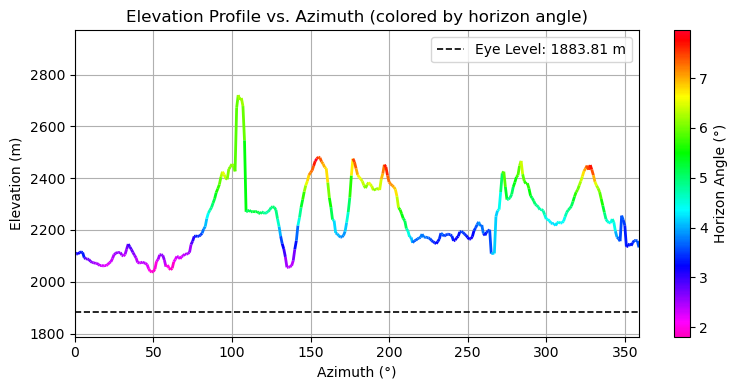

In [42]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell 9: 2D Elevation Profile (Azimuth vs. Elevation) colored by Horizon Angle
# ──────────────────────────────────────────────────────────────────────────────

# For each azimuth, get the max elevation and corresponding horizon angle
elev_profile = pc_df.groupby('az_deg')[['z_elev', 'horizon_angle_deg']].max().reset_index()
azimuths_elev = elev_profile['az_deg'].values
max_elevs = elev_profile['z_elev'].values
h_angles = elev_profile['horizon_angle_deg'].values

# Prepare segments for colored line
points = np.array([azimuths_elev, max_elevs]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Normalize horizon angle for colormap
norm = plt.Normalize(h_angles.min(), h_angles.max())
lc = LineCollection(segments, cmap='gist_rainbow_r', norm=norm)
lc.set_array(h_angles)
lc.set_linewidth(2)

fig, ax = plt.subplots(figsize=(8,4))
ax.add_collection(lc)
ax.set_xlim(azimuths_elev.min(), azimuths_elev.max())

# Add 150m padding to y-axis
ymin = max_elevs.min() - 250
ymax = max_elevs.max() + 250
ax.set_ylim(ymin, ymax)

ax.set_xlabel('Azimuth (°)')
ax.set_ylabel('Elevation (m)')
ax.set_title('Elevation Profile vs. Azimuth (colored by horizon angle)')
plt.axhline(z_eye, color='black', linestyle='--', linewidth=1.2, label=f'Eye Level: {z_eye:.2f} m')
plt.colorbar(lc, ax=ax, label='Horizon Angle (°)')
ax.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

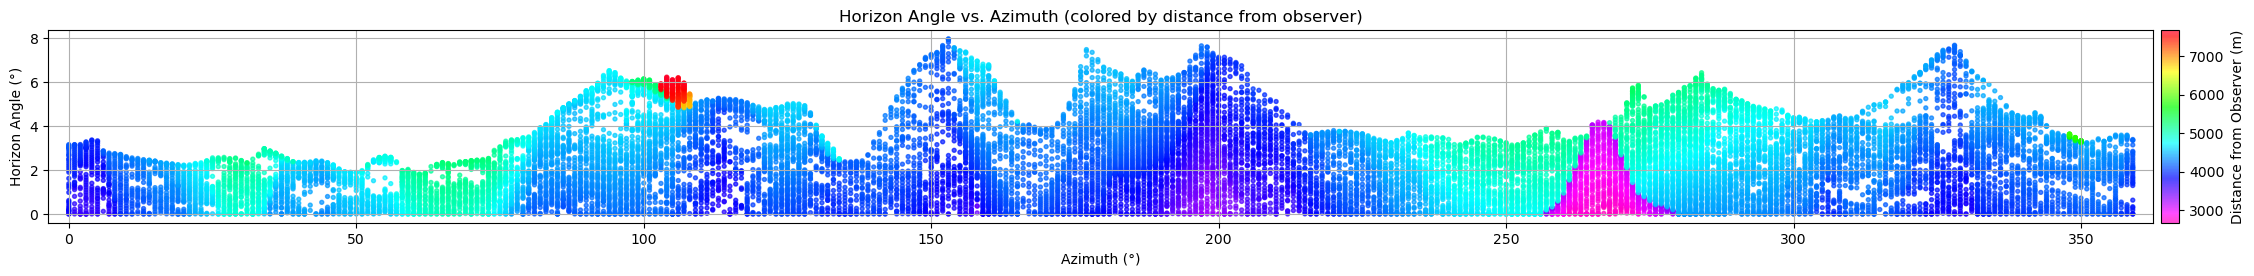

In [43]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell 10: 2D Horizon Angle vs. Azimuth, colored by Distance from Observer
# ──────────────────────────────────────────────────────────────────────────────

# Reduce height from (10, 4) to (10, 2.5) for a more compressed y-axis
fig, ax = plt.subplots(figsize=(10, 2.5))
sc = ax.scatter(
    samples_patch['az_deg'],
    samples_patch['horizon_angle_deg'].clip(lower=0),
    c=samples_patch['r_m'],
    cmap='gist_rainbow_r',
    s=8,
    alpha=0.7
)
ax.set_xlabel('Azimuth (°)')
ax.set_ylabel('Horizon Angle (°)')
ax.set_title('Horizon Angle vs. Azimuth (colored by distance from observer)')

# Set y-limits tightly around the data with a small margin
ymin = samples_patch['horizon_angle_deg'].clip(lower=0).min()
ymax = samples_patch['horizon_angle_deg'].clip(lower=0).max()
margin_y = (ymax - ymin) * 0.05 if ymax > ymin else 1
ax.set_ylim(ymin - margin_y, ymax + margin_y)

# Set x-limits tightly around the data with a slightly larger margin
xmin = samples_patch['az_deg'].min() 
xmax = samples_patch['az_deg'].max() 
margin_x = (xmax - xmin) * 0.01 if xmax > xmin else 1  # widen margin to 3%
ax.set_xlim(xmin - margin_x, xmax + margin_x)

ax.grid(True)

# Widen the axes area to the right, reducing space between plot and colorbar
width_factor = 2.75  # adjust this value to control axes width; 1.00 is a default, plot friendly width, 2.75 plots a more realistic view in terms of the observer
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * width_factor, box.height])

# Place colorbar manually with fixed width (use inches, not pixels)
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size=0.18, pad=0.08)  # 0.18 inch wide colorbar
cb = plt.colorbar(
    sc,
    cax=cax,
    label='Distance from Observer (m)'
)

plt.tight_layout()
plt.show()

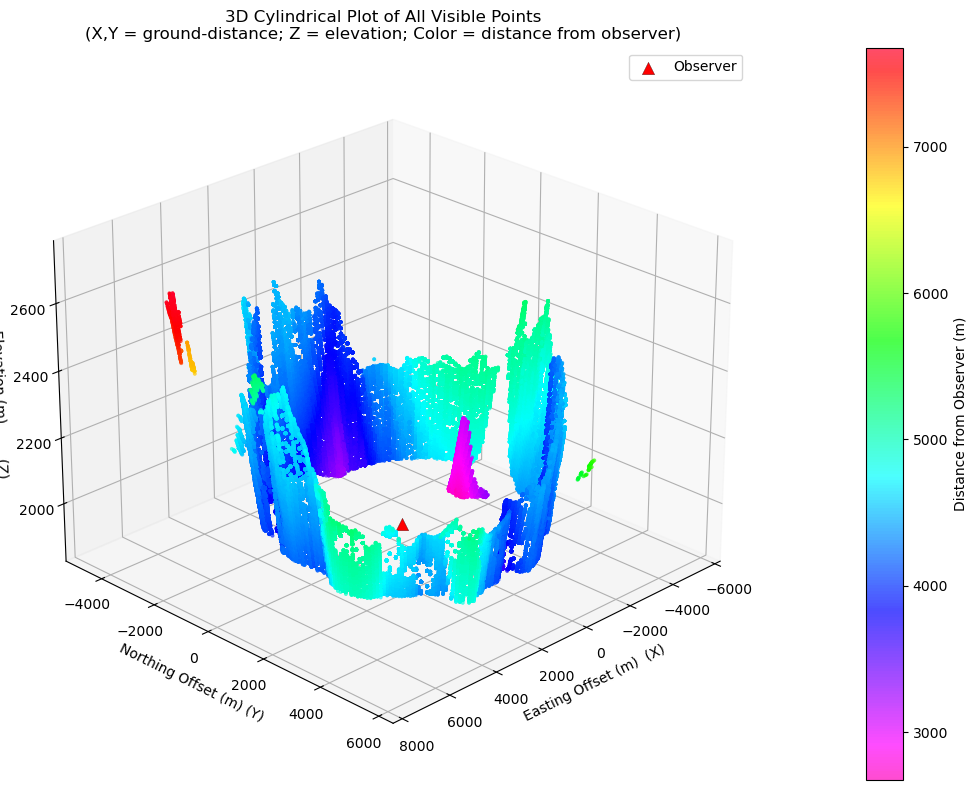

In [44]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell 11: 3D Cylindrical Plot of All Visible Points (Z = elevation, color = distance from observer)
# ──────────────────────────────────────────────────────────────────────────────

# Use all points in pc_df
azs_all = np.deg2rad(pc_df['az_deg'].values)
ranges_all = pc_df['r_m'].values
z_elevs_all = pc_df['z_elev'].values

# Cylindrical coordinates (observer at origin)
X_all = ranges_all * np.sin(azs_all)
Y_all = ranges_all * np.cos(azs_all)
Z_all = z_elevs_all  # Z is elevation

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(X_all, Y_all, Z_all, c=ranges_all, cmap="gist_rainbow_r", s=8, alpha=0.7, edgecolor="none")

ax.set_xlabel("Easting Offset (m)  (X)")
ax.set_ylabel("Northing Offset (m) (Y)")
ax.set_zlabel("Elevation (m)        (Z)")
ax.set_title("3D Cylindrical Plot of All Visible Points\n(X,Y = ground-distance; Z = elevation; Color = distance from observer)")

# Observer at origin
ax.scatter([0], [0], [z_eye], color="red", marker="^", s=80, edgecolors="black", linewidths=0.2, label="Observer")

ax.view_init(elev=25, azim=45)
cbar = fig.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label("Distance from Observer (m)")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()